In [1]:
# https://github.com/gibsramen/gUMAP/blob/master/notebooks/pokemon_umap.ipynb

In [2]:
import base64; import glob; from io import BytesIO; import os; import re
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.plotting import figure, show, output_notebook
from bokeh.resources import CDN
from bokeh.embed import file_html
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import umap
import warnings; warnings.filterwarnings("ignore")
#plt.style.use('fivethirtyeight')
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [3]:
pokemon_dm_gower       =   pd.read_csv("./data/pokemon_dm_gower.csv", sep=",", index_col=0)
pokemon_dm_gower_cat   =   pd.read_csv("./data/pokemon_dm_gower_only_categorical.csv", sep=",", index_col=0)

In [4]:
pokemon_df = pd.read_csv("./Data/pokemon_alopez247.csv", index_col=0)
pokemon_df = pokemon_df.reset_index(drop=True)
for col in pokemon_df.columns:
    if pokemon_df[col].dtype == 'bool':
        pokemon_df[col] = pokemon_df[col].astype(str)
pokemon_df.head()

,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,Charmander,Fire,NaN,309,39,52,43,60,50,65,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


In [5]:
def embeddable_image(data):
    """Get image to embed for bokeh plot"""
    # adapted from umap documentation
    # https://umap-learn.readthedocs.io/en/latest/basic_usage.html
    buffer = BytesIO()
    data.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [6]:
def plot_bokeh(umap_results, title, name=None, location=None, **kwargs):
    plot_df = pd.DataFrame(umap_results)
    plot_df = plot_df.join(pokemon_df)
    plot_df.rename(columns={0:'x', 1:'y'}, inplace=True)

    datasource = ColumnDataSource(plot_df)

    plot_figure = figure(title=title, plot_width=600, plot_height=600, tools=('pan, wheel_zoom, reset'))

    plot_figure.add_tools(HoverTool(tooltips="""
    <div>
        <div>
            <img src='@img' style='float: left; margin: 5px 5px 5px 5px'/>
        </div>
        <div>
            <span style='font-size: 16px; color: #224499'>Pokemon:</span>
            <span style='font-size: 18px'>@Name</span>
        </div>
    </div>
    """))

    plot_figure.circle('x','y',source=datasource,**kwargs,)
    plot_figure.title.text_font_size = '14pt'
    show(plot_figure)

    if name is not None:
        save_to_html(plot_figure, name, location)

In [7]:
def save_to_html(plot, name, location):
    html = file_html(plot, CDN, name)
    with open(location, "w+") as f:
        f.write(html) 

In [8]:
all_egg_groups = set(pokemon_df["Egg_Group_1"]) & set(pokemon_df["Egg_Group_2"])
all_egg_groups = sorted(all_egg_groups)

In [9]:
def get_either_param(row, param1, param2, value):
    if row[param1] == value or row[param2] == value:
        return value
    else:
        return "other"
    
""" Return whether Pokemon has value in param. Parameters:
        row: single row from pd.DataFrame.iterrows()
        param1: first column to check. param2: second column to check
        value: value in column to associate
    
Returns:  value/other: if value is present in row, return it. else, return "other"
Usage: df["color"] = df.apply(get_either_param, 1, param1="Egg_Group_1", param2="Egg_Group_2", value="Amorphous") """

' Return whether Pokemon has value in param. Parameters:\n        row: single row from pd.DataFrame.iterrows()\n        param1: first column to check. param2: second column to check\n        value: value in column to associate\n    \nReturns:  value/other: if value is present in row, return it. else, return "other"\nUsage: df["color"] = df.apply(get_either_param, 1, param1="Egg_Group_1", param2="Egg_Group_2", value="Amorphous") '

In [10]:
def plot_egg_group_sns(umap_results, suptitle, **kwargs):
    df = pd.DataFrame(umap_results, columns=["x", "y"]).join(pokemon_df)
    # plt.rcParams["font.family"] = "Helvetica"
    plt.rcParams["figure.facecolor"] = "white"
    fig, axes = plt.subplots(3, 5, figsize=(20, 10), dpi=300, subplot_kw={'aspect': 'equal'})
    plt.subplots_adjust(wspace=0.05, hspace=0.25)
    
    for i, this_egg_group in enumerate(all_egg_groups): 
        ax = axes.flat[i]
        df["color"] = df.apply(get_either_param, 1, param1="Egg_Group_1",
                               param2="Egg_Group_2", value=this_egg_group)

        sns.scatterplot(data=df, x="x", y="y", hue="color", s=15,
            palette={this_egg_group: "#484848", "other": "#D3D3D3"},
            legend=False, edgecolor="black", linewidth=0, ax=ax, **kwargs,)
        ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)
        ax.set_title(this_egg_group.replace("_", " "), fontsize=24)
        plt.suptitle(suptitle, fontsize=30)
        plt.show()

In [11]:
pokemon_df_only_num = pokemon_df[['Total', 'HP', 'Attack', 'Defense', 
                                  'Sp_Atk', 'Sp_Def', 'Speed', 'Height_m', 
                                  'Weight_kg', 'Catch_Rate']].reset_index(drop=True)
pokemon_df_only_num.head()

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Height_m,Weight_kg,Catch_Rate
0,318,45,49,49,65,65,45,0.71,6.9,45
1,405,60,62,63,80,80,60,0.99,13.0,45
2,525,80,82,83,100,100,80,2.01,100.0,45
3,309,39,52,43,60,50,65,0.61,8.5,45
4,405,58,64,58,80,65,80,1.09,19.0,45


In [12]:
reducer_only_num    = umap.UMAP(min_dist=0.4, n_neighbors=8, random_state=42)
embedding_only_num  = reducer_only_num.fit_transform(pokemon_df_only_num)

In [13]:
plot_bokeh(embedding_only_num, "Only Numeric Features", "pokemon_only_num",
    "./Data/html/pokemon_only_num.html", size=5, line_color='black', line_width=0.8, color='red')

In [14]:
#  plot_egg_group_sns(embedding_only_num, "Only Numeric Features")

In [15]:
reducer_gower = umap.UMAP(metric="precomputed", min_dist=0.4, n_neighbors=8, random_state=42)
embedding_gower = reducer_gower.fit_transform(pokemon_dm_gower)

In [16]:
gower_umap_df = pd.DataFrame(embedding_gower).join(pokemon_df)
gower_umap_df.rename(columns={0: 'x', 1: 'y'}, inplace=True)
gower_umap_df.head()

,x,y,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,-3.601019,-4.182303,Bulbasaur,Grass,Poison,318,45,49,49,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,-3.554405,-4.527971,Ivysaur,Grass,Poison,405,60,62,63,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,-3.370067,-4.485699,Venusaur,Grass,Poison,525,80,82,83,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,-1.181585,-4.485912,Charmander,Fire,NaN,309,39,52,43,60,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,-1.200069,-4.360712,Charmeleon,Fire,NaN,405,58,64,58,80,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


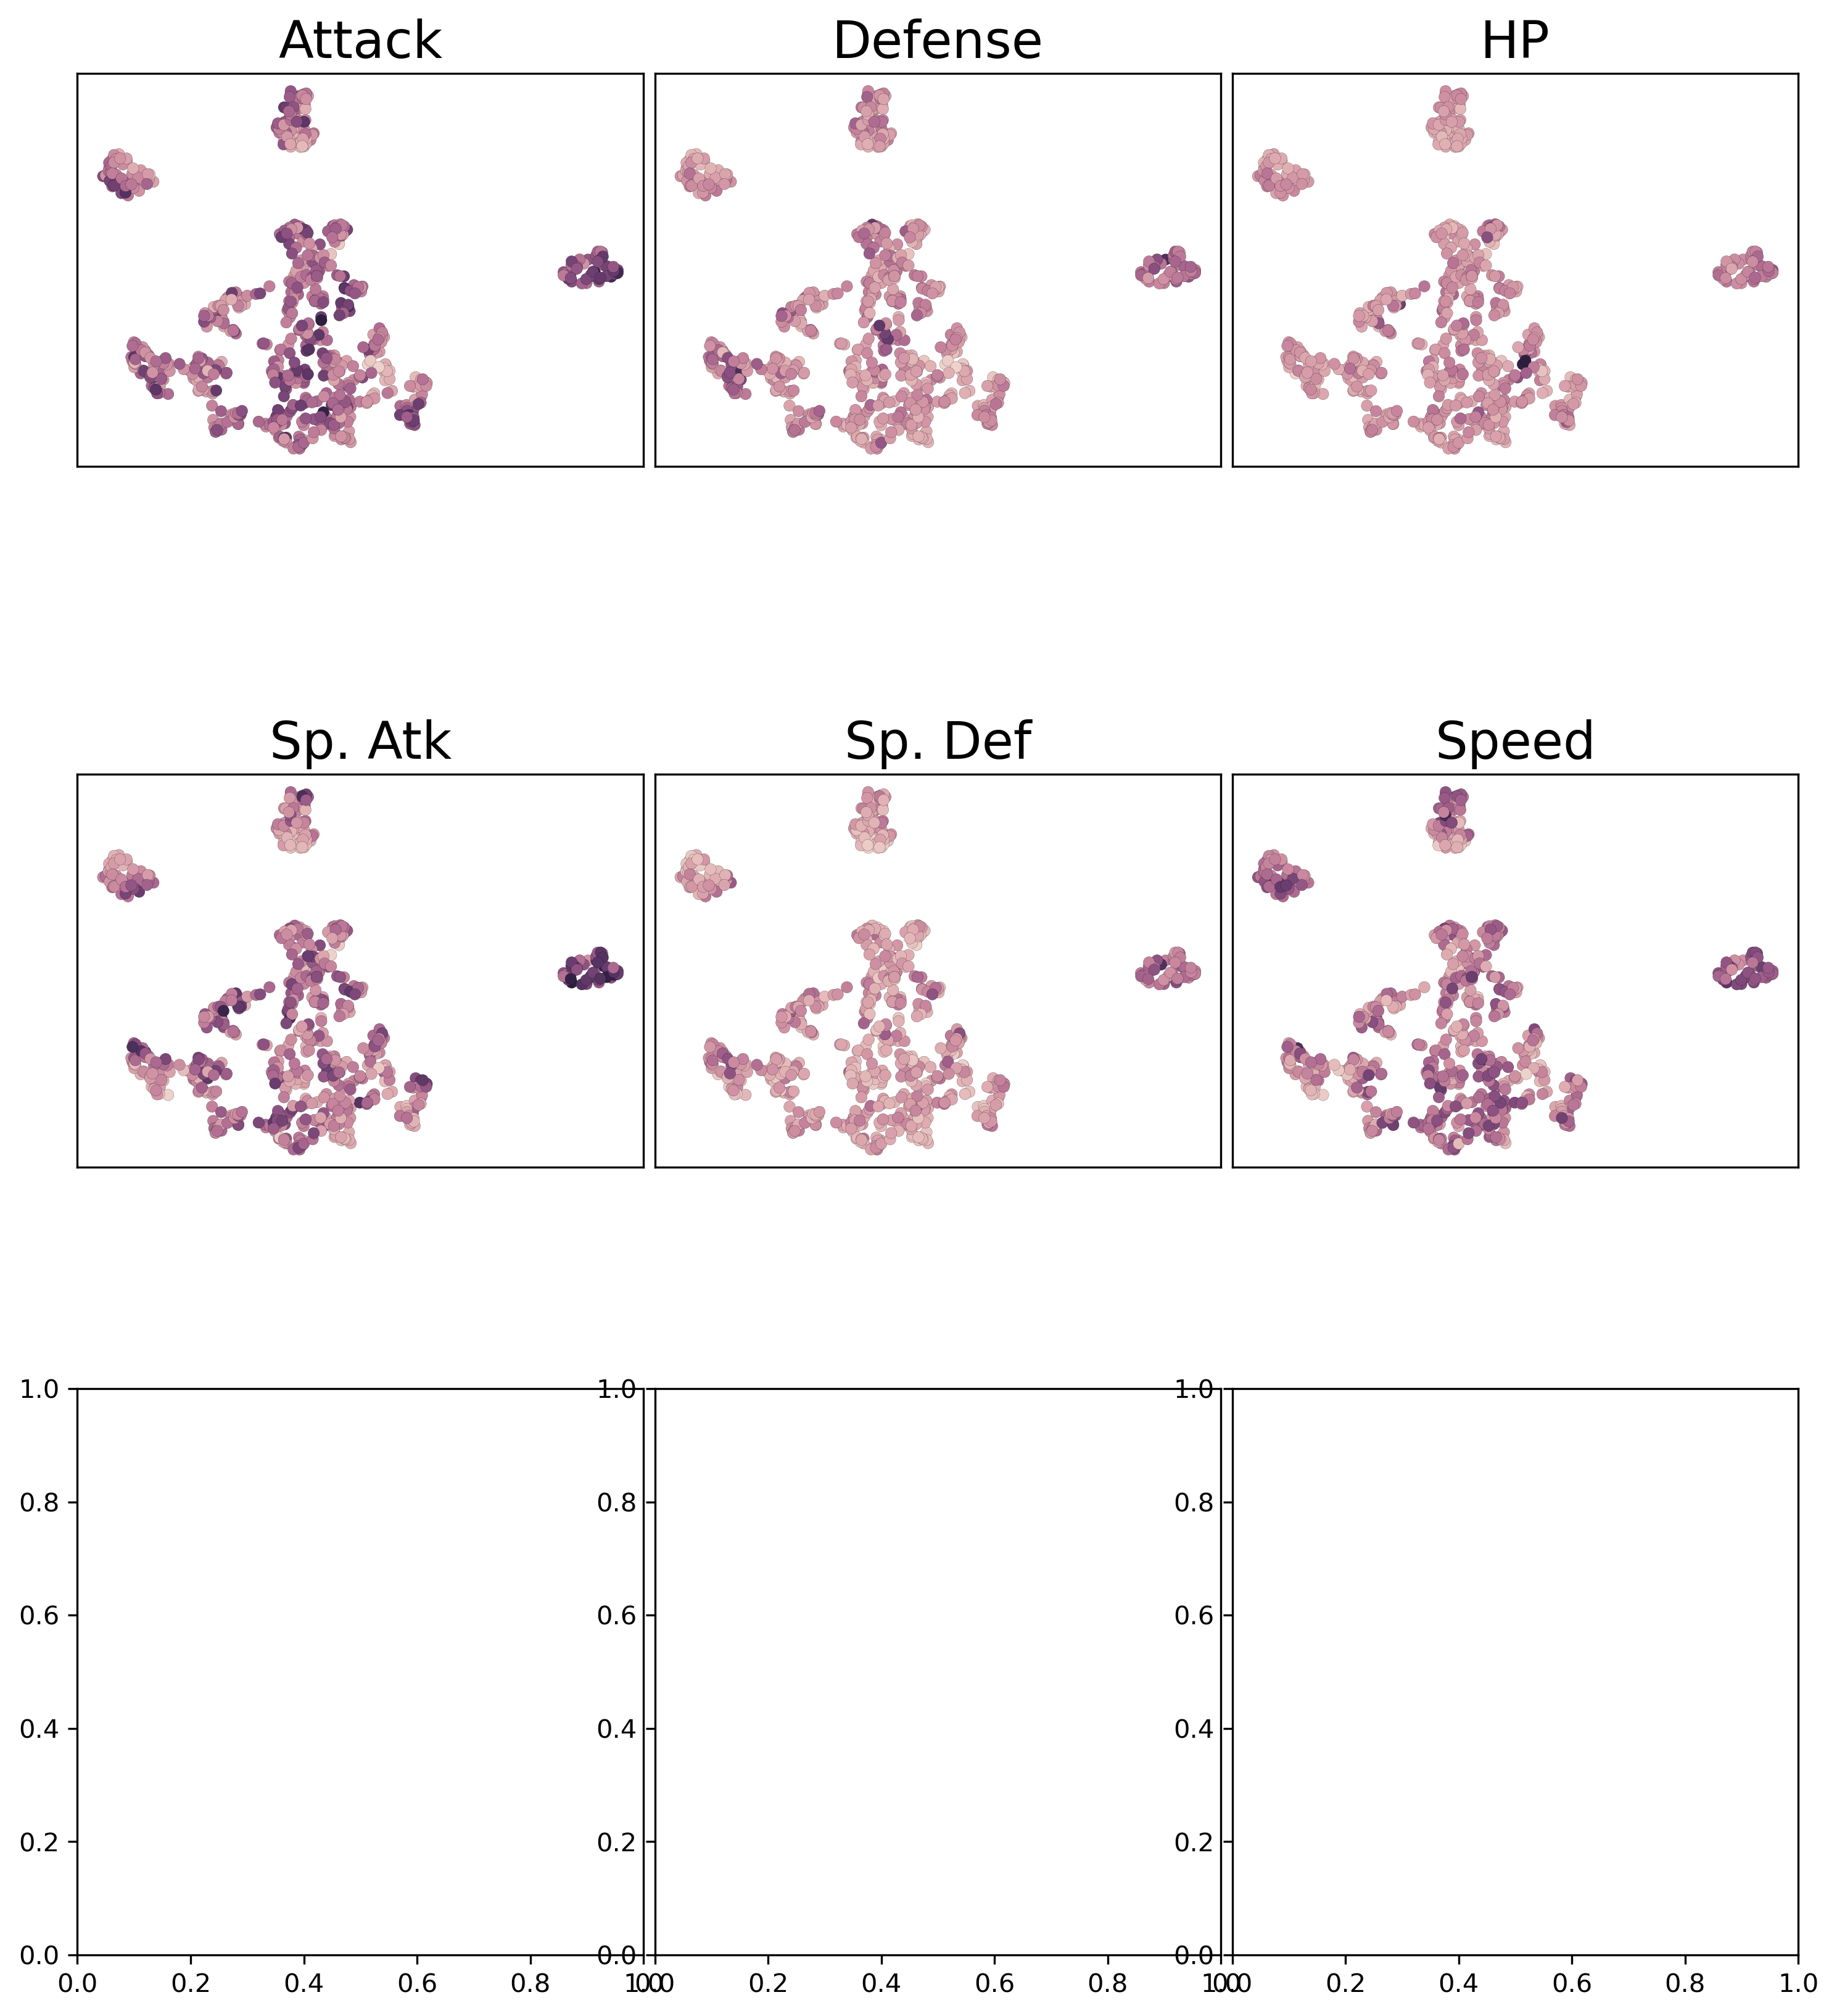

In [17]:
stats = ["Attack", "Defense", "HP", "Sp_Atk", "Sp_Def", "Speed"]
    
# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["figure.facecolor"] = "white"
fig, axes = plt.subplots(3, 3, figsize=(12, 15), dpi=300, subplot_kw={'aspect': 'equal'})
plt.subplots_adjust(wspace=0.02, hspace=0.01)

#for i in [0, 2]:
#    axes[2, i].set_visible(True)

for i, this_stat in enumerate(stats):       
    if i == 6:
        ax = axes[2, 1]
    else:
        ax = axes.flat[i]
    
    sns.scatterplot(
        data=gower_umap_df,
        x="x",
        y="y",
        s=20,
        hue=this_stat,
        cmap=sns.cubehelix_palette(as_cmap=True),
        legend=False,
        edgecolor="black",
        linewidth=0.05,
        alpha=1,
        ax=ax,
    )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(this_stat.replace("_", ". "), fontsize=20)

# plt.suptitle("gUMAP Pokémon Stats", fontsize=25, y=0.92)
#plt.savefig("./gUMAP_pokemon_stats.png", dpi=600, bbox_inches="tight")
#plt.tight_layout()
plt.show()

In [18]:
type_dict = {
    "Fire": "#F08030",      "Grass": "#78C850",      "Water": "#6890F0",     "Bug": "#a8b820",
    "Normal": "#a8a878",    "Poison": "#A040A0",     "Electric": "#F8D030",  "Ground": "#E0C068",
    "Dark": "#705848",      "Psychic": "#F85888",    "Dragon": "#7038F8",    "Flying": "#A890F0",
    "Fairy": "#EE99AC",     "Fighting": "#C03028",   "Ghost": "#705898",     "Rock": "#B8A038",
    "Steel": "#B8B8D0",     "Ice": "#98D8D8",
}

In [19]:
all_types = gower_umap_df["Type_1"].unique()

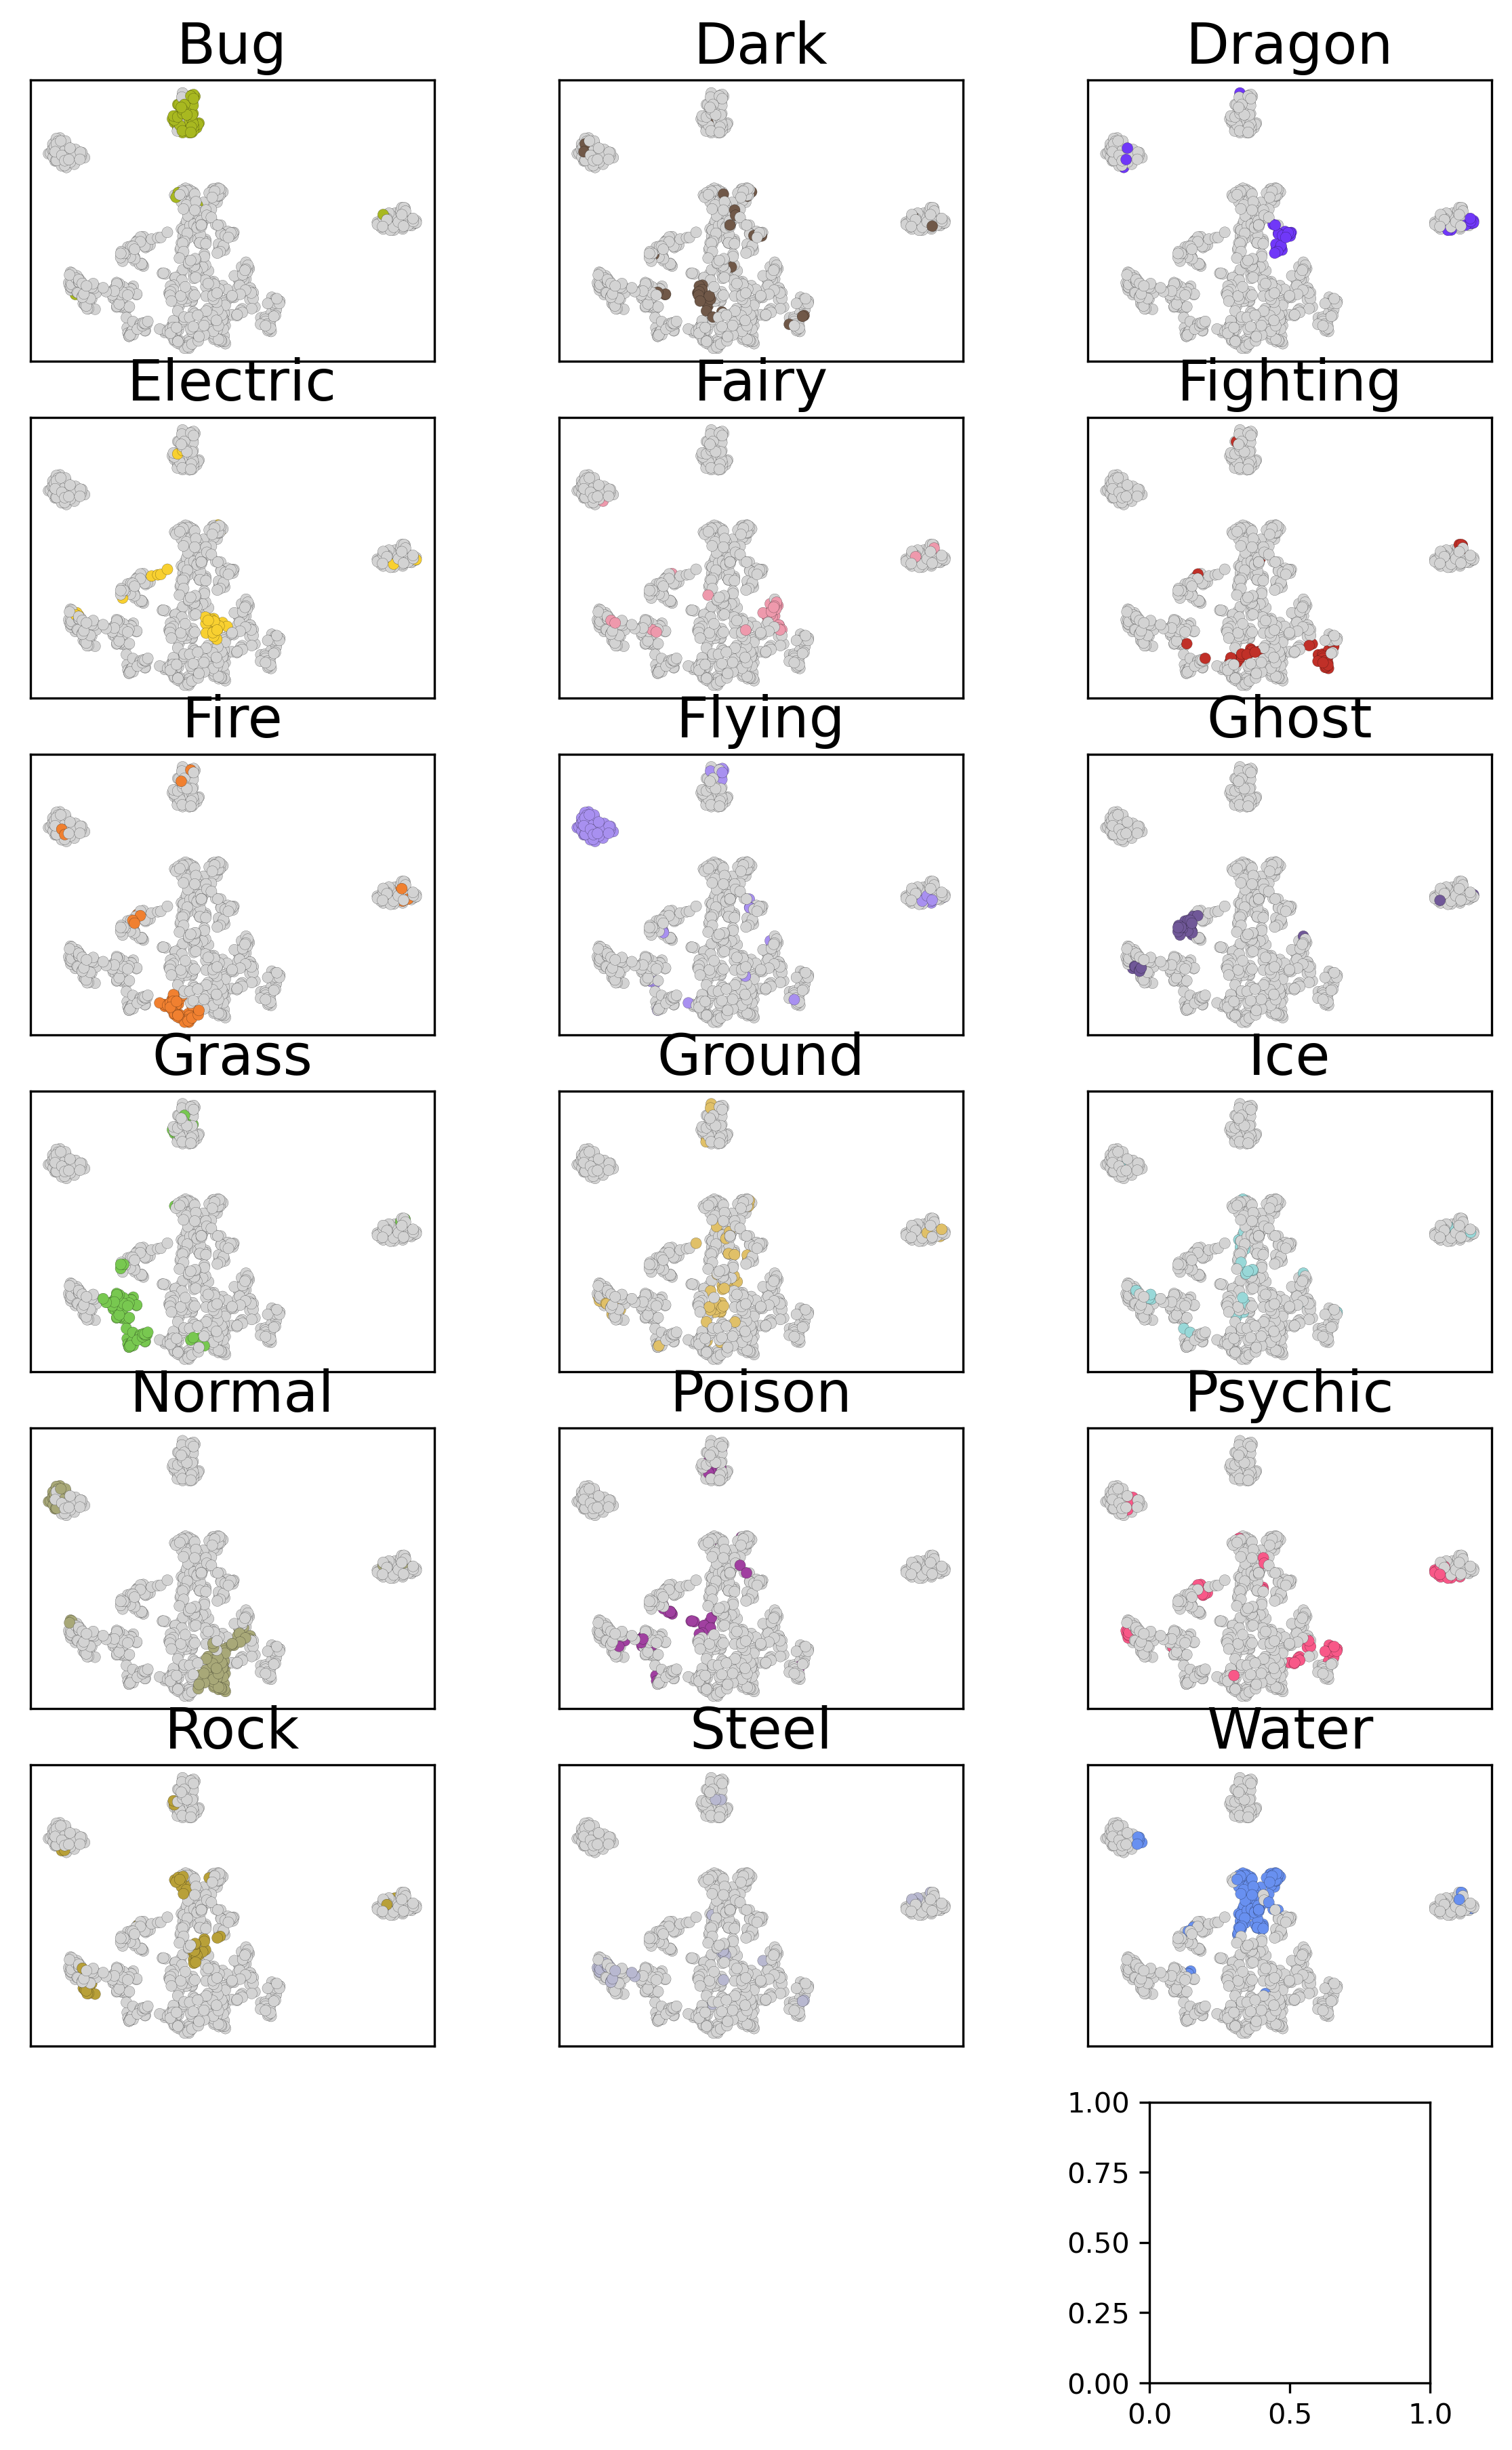

<Figure size 432x288 with 0 Axes>

In [22]:
# plt.rcParams["figure.facecolor"] = "white"
fig, axes = plt.subplots(7, 3, figsize=(10, 15), dpi=300, subplot_kw={'aspect': 'equal'})
plt.subplots_adjust(wspace=0.02, hspace=0.2)

for i, this_type in enumerate(sorted(all_types)):
    ax = axes.flat[i]
    df_copy = gower_umap_df.copy()
    color_vals = df_copy.apply(
        get_either_param, 
        1, 
        param1="Type_1",
        param2="Type_2",
        value=this_type,
    )
    df_copy["color"] = color_vals
    
    sns.scatterplot(
        data=df_copy,
        x="x",
        y="y",
        s=15,
        hue="color",
        palette={this_type: type_dict[this_type], "other": "#D3D3D3"},
        legend=False,
        edgecolor="black",
        linewidth=0.05,
        alpha=1,
        ax=ax,
    )
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(this_type, fontsize=20)
#plt.tight_layout()
#plt.suptitle("gUMAP Pokémon Location by Type", fontsize=25, y=0.93)

i += 1
while i < 20:
    axes.flat[i].set_visible(False)
    i += 1

plt.show()
plt.savefig("gUMAP_pokemon_location_by_type.png", dpi=300, bbox_inches="tight")